# Chapter 14: Variation and the Process Principle

For additional context see chapter 14 of [The Virus of Variation & Process Behavior Charts: A Guide for the Perplexed](https://www.brokenquality.com/book).

In [1]:
# Import libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from process_improvement import xmr_charts as xmr
from process_improvement import comparison_charts as cc

%matplotlib inline

## Get data

In [2]:
# Dataset url
dataset_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation-and-pbcs/refs/heads/main/data/14-electrical-resistance-of-insulation-in-megohms-shewhart-data.csv'

# Get data
def get_data() -> pd.DataFrame:
    return pd.read_csv(dataset_url)

# Get data
df = get_data()

# Make 'Year' column dtype string
df['Value'] = df['Value'].astype('string')

# Show df
df.head()

,Stage,Value,Resistance
0,Initial,1,5045
1,Initial,2,4350
2,Initial,3,4350
3,Initial,4,3975
4,Initial,5,4290


## Group df by stage

In [3]:
# Get groups
grouped_df = df.groupby('Stage')

# Create dataframe of initial stage
initial_df = grouped_df.get_group('Initial')
# Calculate 'Moving Ranges' column
initial_df = initial_df.copy()
initial_df['Moving Ranges'] = abs(initial_df['Resistance'].diff())
# Create dataframe of only Dublin General data
additional_df = grouped_df.get_group('Additional').reset_index(drop=True)

## Fig 14.2: The traditional view of quality

This figure does not use the imported dataset.

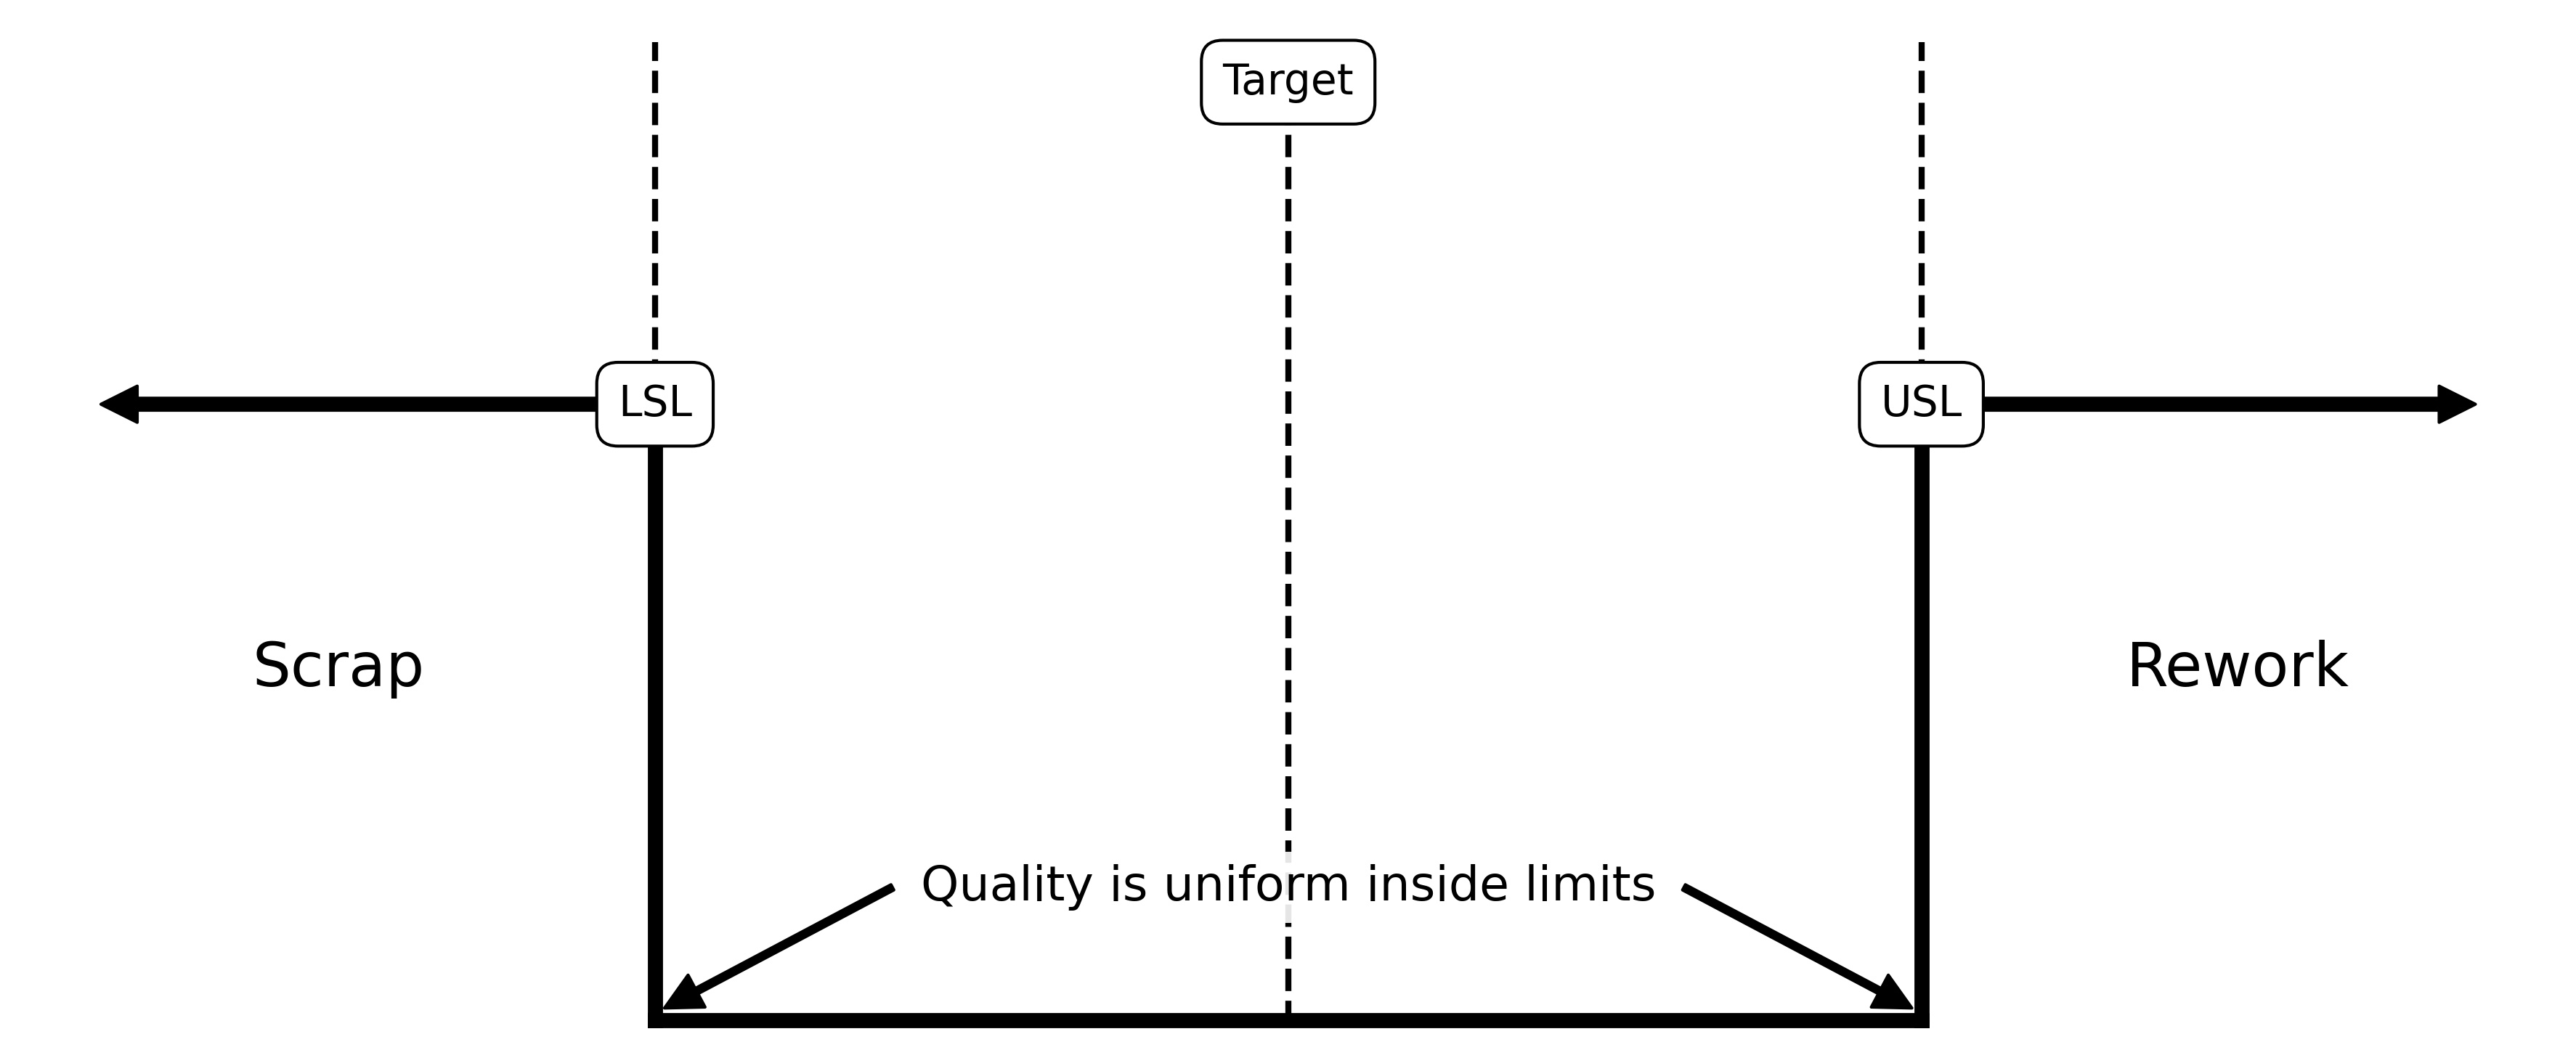

In [4]:
# Create figure
fig, ax = plt.subplots(figsize=(15, 6), dpi=300)

# Specification limits (LSL, USL, Target)
spec_limits = [-2, 0, 2]
for x in spec_limits:
    ax.axvline(x, ls='--', lw=2, color='black', ymin=0.005, ymax=0.9 if x == 0 else 0.98)

# Outside limit horizontal arrows
for x_start, x_end in [(-3.75, -2), (3.75, 2)]:
    ax.annotate('', xy=(x_start, 0.31), xytext=(x_end, 0.31),
                arrowprops=dict(edgecolor='black', facecolor='black'))

# Text labels for limits
labels = { -2: "LSL", 2: "USL", 0: "Target"}
for x, label in labels.items():
    ax.text(x, 0.31 if x else 0.47, label, ha='center', va='center', fontsize=14,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=0.5))

# Central quality message
ax.text(0, 0.07, 'Quality is uniform inside limits',
        ha='center', va='center', fontsize=16,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))

# Arrows pointing inside limits
for x_start, x_end in [(-1.97, -1.25), (1.97, 1.25)]:
    ax.annotate('', xy=(x_start, 0.01), xytext=(x_end, 0.07),
                arrowprops=dict(edgecolor='black', facecolor='black', width=2))

# Thick boundary lines at LSL and USL
for x in [-2, 2]:
    ax.axvline(x, ls='-', lw=5, color='black', ymax=0.62)

# Horizontal connect spec limits
ax.axhline(0.004, ls='-', lw=5, color='black', xmin=0.25, xmax=0.75)

# 'Scrap' and 'Rework' labels
ax.text(-3, 0.17, 'Scrap', ha='center', fontsize=20)
ax.text(3, 0.17, 'Rework', ha='center', fontsize=20)

# Remove top and right spines for cleaner look
sns.despine()
ax.spines[['left', 'bottom']].set_alpha(0.5)

# Set axis limits
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])

# Remove axes
ax.set_axis_off()

# Show plot
plt.show()

## Fig 14.8: XmR Chart of initial resistance measurements

The XmR Chart of initial resistance measurements is presented in two ways below. The first version calculates all the requisite values and performs the requisite plotting outside of the Python package `process_improvement.py`. The second versions calculates and creates all the requisites values and plotting using the `process_improvement.py` Python package.

In [5]:
# Calculate mean of resistance measurements
mean = round(initial_df['Resistance'].mean(),2)

# Calculate average moving range
average_mR = round(initial_df['Moving Ranges'].mean(),2)

# Set values for the numeric constants C1 and C2
C1 = 2.660
C2 = 3.268

# Calculate the Upper Range Limit
UPL = round(mean + (C1*average_mR),2)
# Calculate the Lower Process Limit
LPL = round(max(0, mean - (C1*average_mR)),2) # Note the max condition 
# Calculate the Upper Range Limit
URL = round(C2*average_mR,2)

# Show the results 
print('UPL:',UPL, 'LPL:',LPL,'URL:',URL)

UPL: 5346.21 LPL: 3650.15 URL: 1041.87


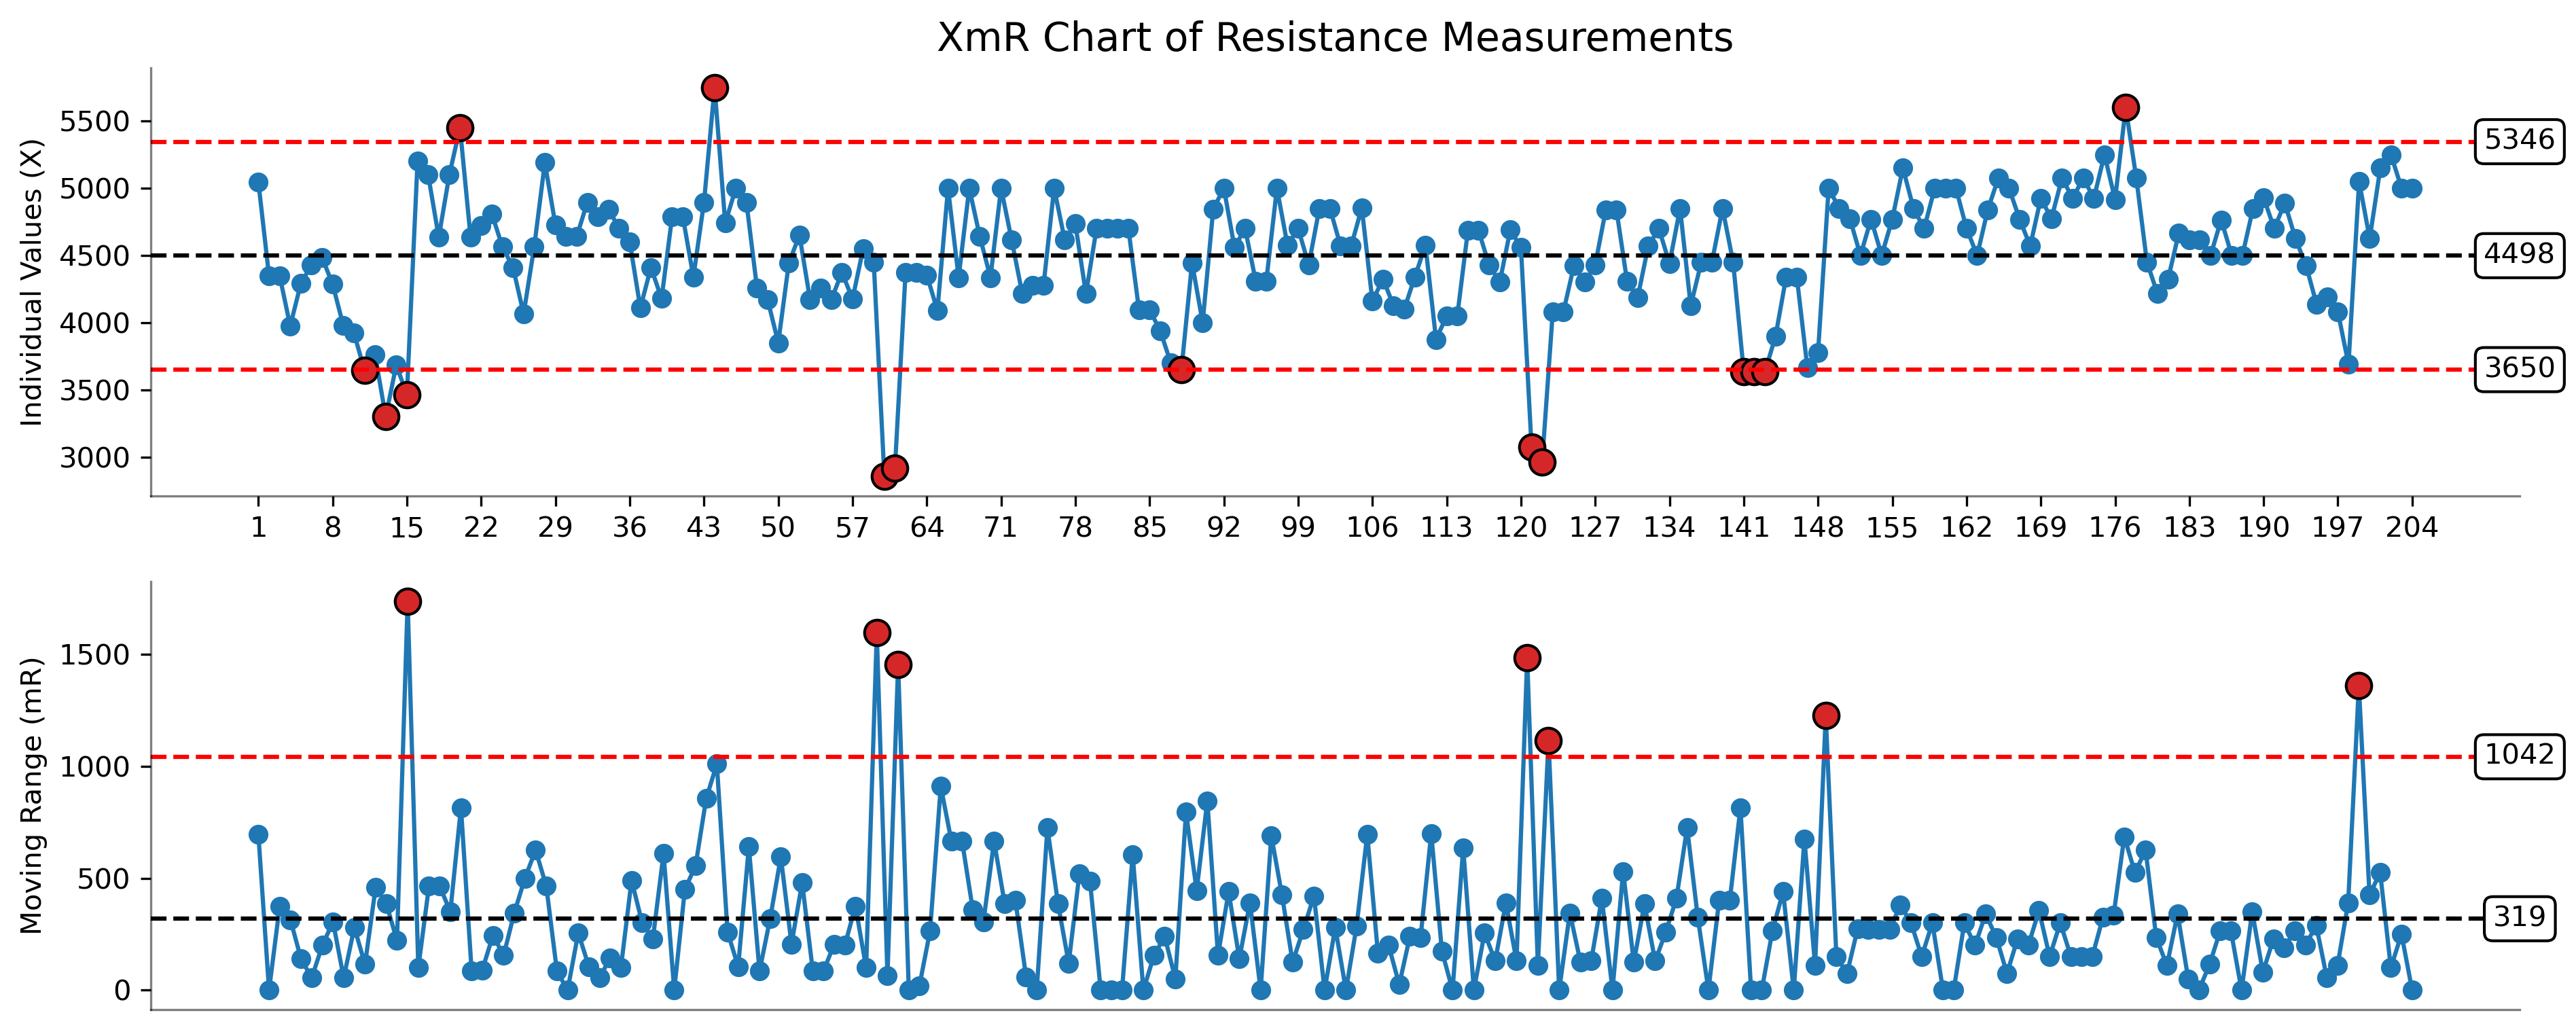

In [6]:
# Extract Data
data = initial_df['Resistance']
labels = initial_df['Value']
moving_ranges = initial_df['Moving Ranges']

# Define Process Limits
xchart_lines = [(mean, 'black'), (UPL, 'red'), (LPL, 'red')]
mrchart_lines = [(average_mR, 'black'), (URL, 'red')]

# Mask values outside limits
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)

# Setup Figure
fig, axs = plt.subplots(figsize=(15, 6), 
                        nrows=2, 
                        ncols=1, 
                        dpi=300)

# X-Chart (Individuals Chart)
axs[0].plot(labels, data, marker='o', label="Data")
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Add Process Limits
for value, color in xchart_lines:
    axs[0].axhline(value, ls='--', c=color)

# Add Labels for Process Limits
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
for value, label in [(UPL, UPL), (LPL, LPL), (mean, mean)]:
    axs[0].text(axs[0].get_xlim()[1] * 1.0, value, round(value),
                color='black', ha='center', va='center', bbox=bbox_props)

# X-Axis Formatting
tick_interval = 7
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center')

# Moving Range Chart (mR Chart)
axs[1].plot(labels, moving_ranges, marker='o', label="Moving Range")
axs[1].plot(labels, url_greater, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Add Process Limits
for value, color in mrchart_lines:
    axs[1].axhline(value, ls='--', c=color)

# Add Labels for Process Limits
for value, label in [(URL, URL), (average_mR, average_mR)]:
    axs[1].text(axs[1].get_xlim()[1], value, round(value),
                color='black', ha='center', va='center', bbox=bbox_props)

# Titles and Labels
axs[0].set_ylabel("Individual Values (X)")
axs[0].set_xlabel("")
axs[0].set_title("")

# Remove xticks on moving range chart
axs[1].set_xticks([])
axs[1].set_ylabel("Moving Range (mR)")

# Remove spines
sns.despine()
# Set alpha values
for val in range(0,2):
    axs[val].spines[['left','bottom']].set_alpha(0.5)

# Add arrow annotation to highlight May-1847
axs[0].annotate('Hand washing begins\nmid-May 1847', 
             xy=(76.2,12.5), 
             xytext=(89,21), 
             color='black', 
             fontsize=14,
             ha='center',
             arrowprops=dict(facecolor='black'),
             bbox=dict(facecolor='white',boxstyle='round',edgecolor='black'))

# Set titles
axs[0].set_title("XmR Chart of Resistance Measurements", 
                 fontsize=14)

# Show Plot
plt.show()

### Generate XmR Chart using process_improvement.py Python package

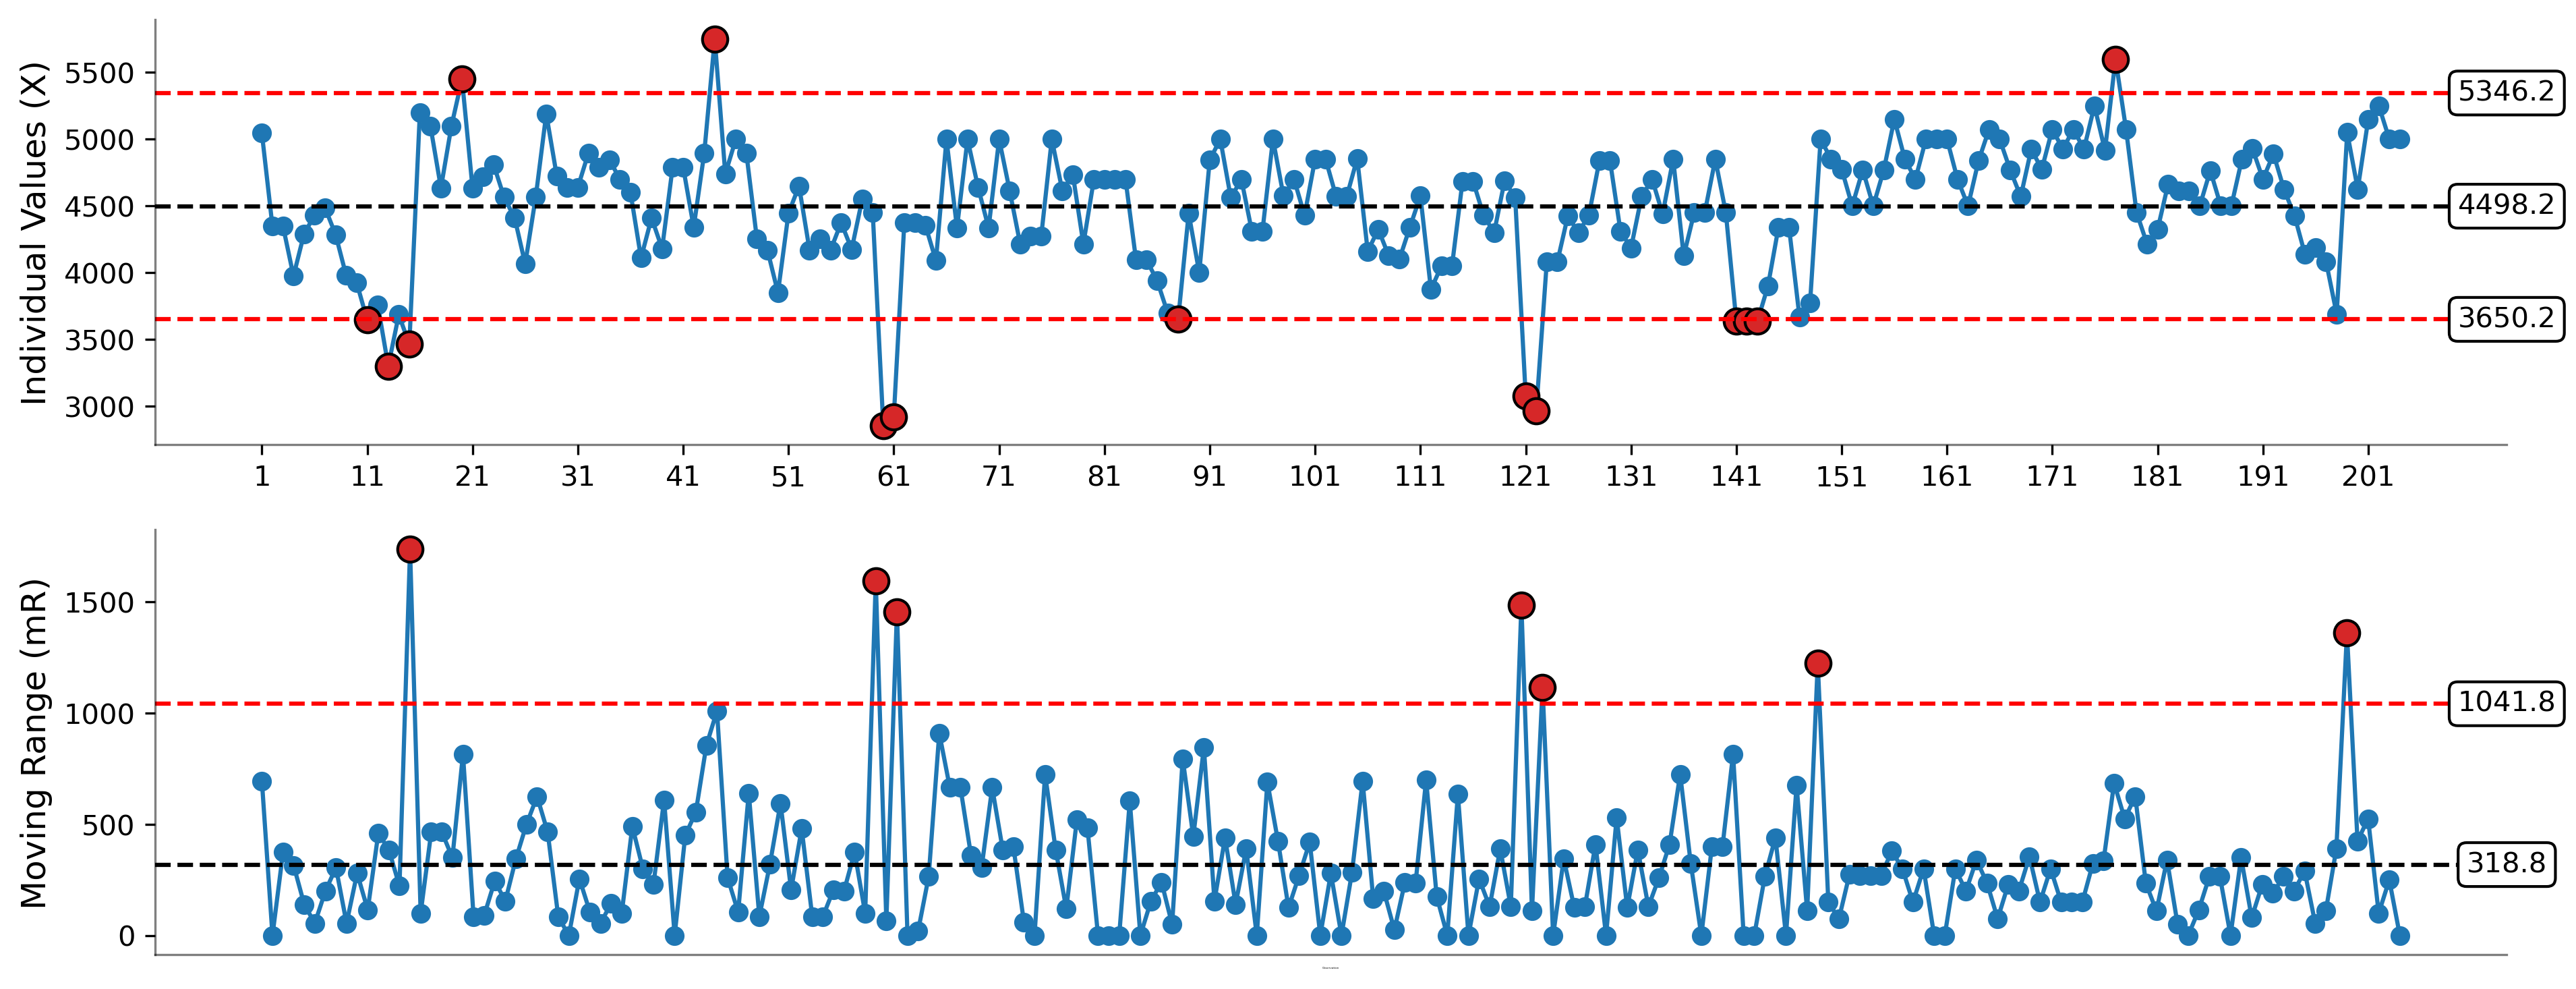

In [7]:
# Generate using xmrchart function from process_improvement.py
initial_results = xmr.xmrchart(initial_df, 'Resistance', 'Value', 
                                  tickinterval=10, round_value=1)

In [8]:
# Show initial_df XmR Chart results
initial_results['XmR Chart Statistics']

,Chart,PBC Params,Param Values
0,X-Chart,Mean,4498.2
1,X-Chart,UPL,5346.2
2,X-Chart,LPL,3650.2
3,X-Chart,PLR,1696.0
4,mR-Chart,Ave. mR,318.8
5,mR-Chart,URL,1041.8


## Fig 14.9: Comparison XmR Chart of initial and additional resistance measurements

In [9]:
# Create list of stages
df_list = [initial_df, additional_df]
# Create list of titles for subplots
titles_list = ['Initial Measurements', 'Additional Measurements']

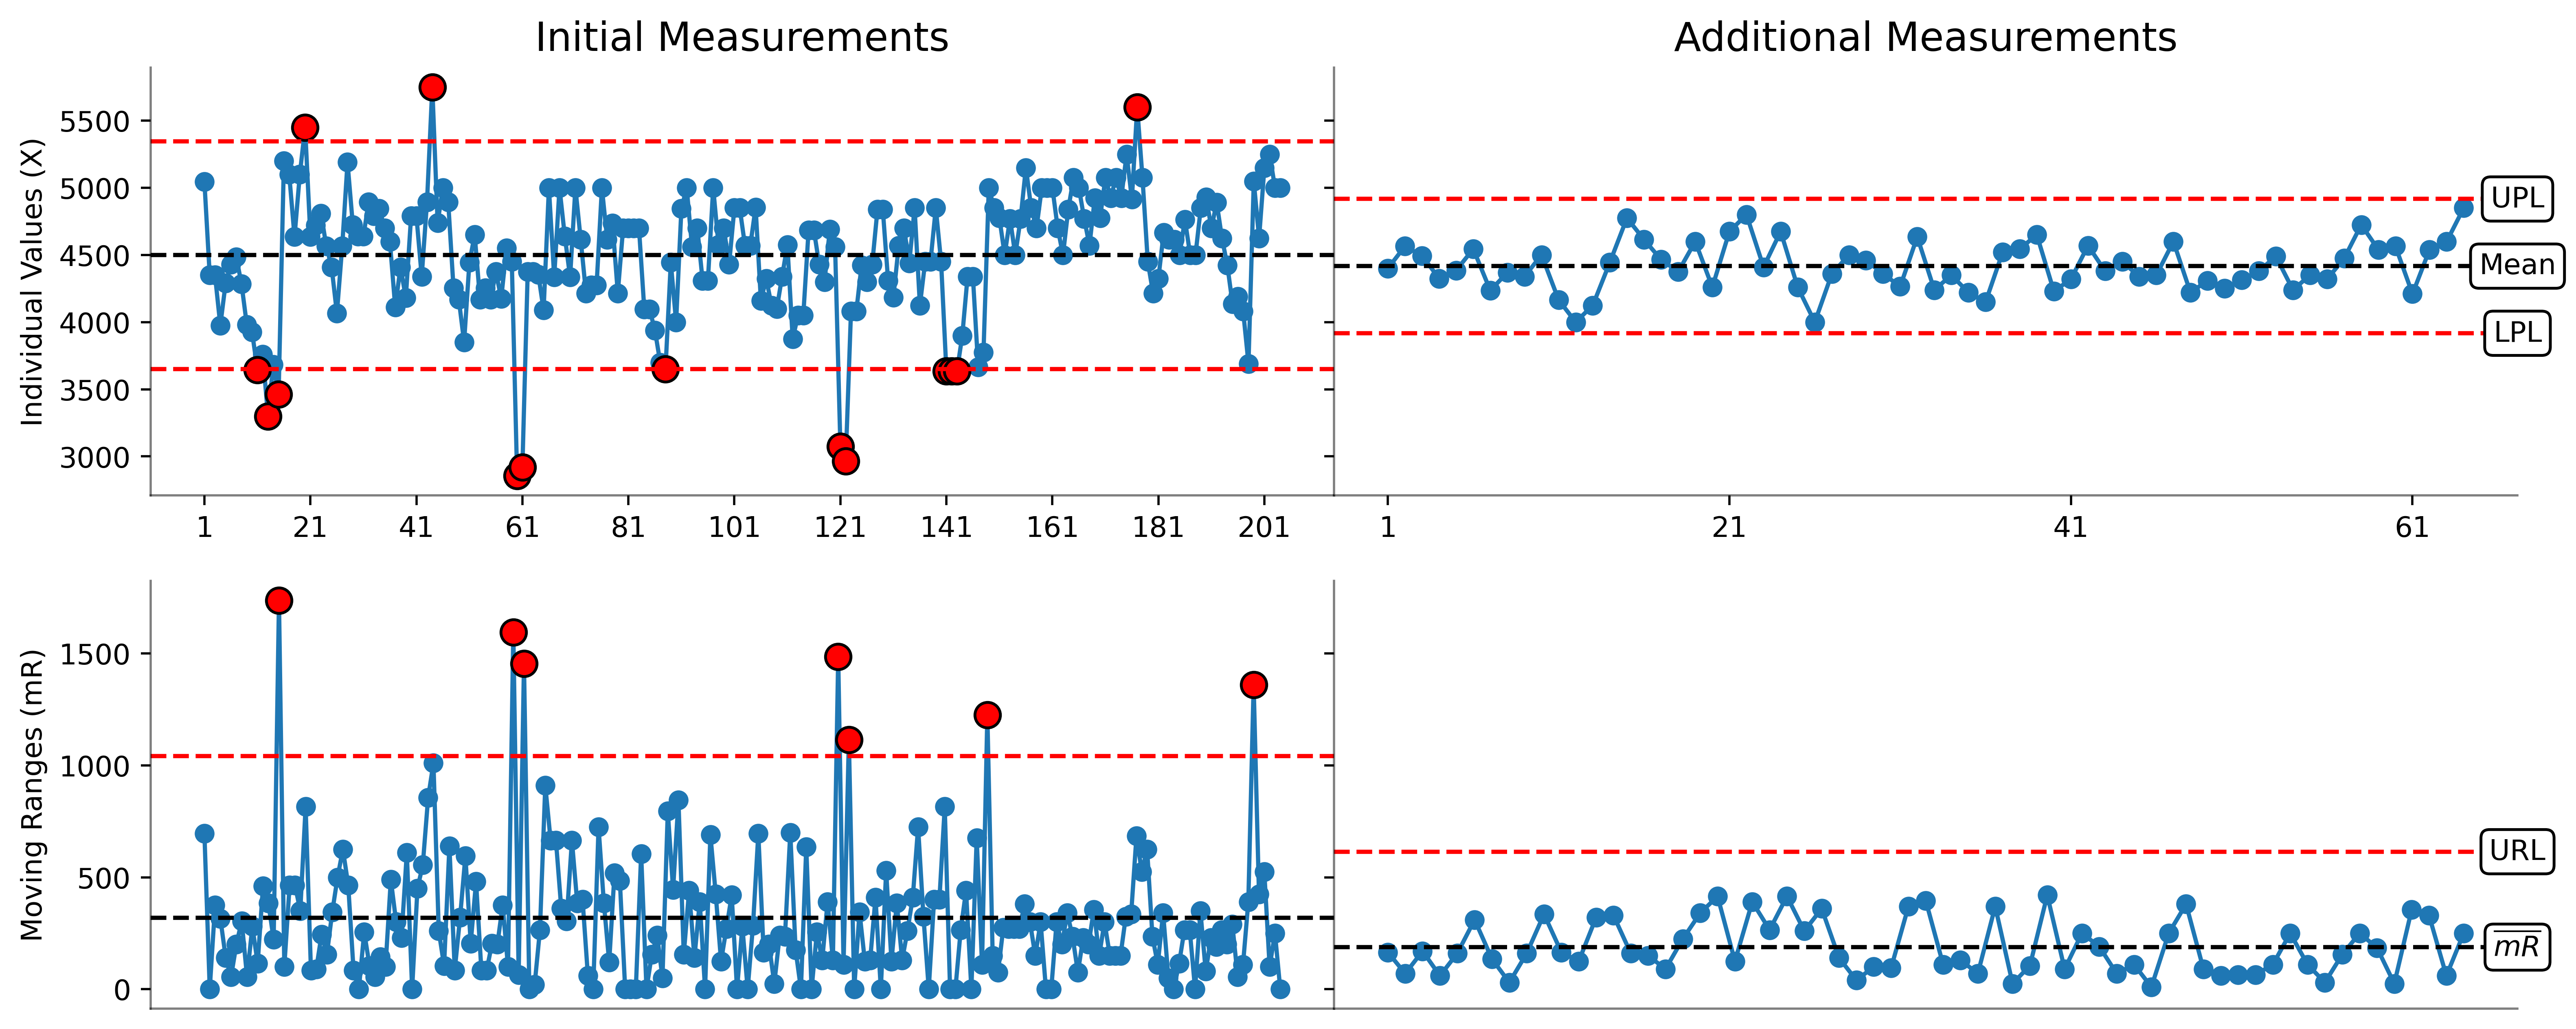

In [11]:
# Create comparison XmR Chart
xmr_comp_results = cc.xmr_comparison(df_list, 'Resistance', 'Value',
                                     titles_list, tickinterval=20, figsize=(15,6))